In [69]:
import os
import functools
import multiprocessing
from typing import Tuple, List, Callable

import pandas as pd
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim
from numba import jit, njit
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt

In [4]:
path_data = os.path.join(os.getcwd(), 'data_modified')

image_names = os.listdir(path_data)
image_sets = set([x.split('_')[0] for x in image_names])

In [5]:
image_sets

{'art', 'books', 'cones', 'dolls', 'reindeer', 'teddy'}

In [6]:
@njit
def normalized_cross_correlation(patch1: np.ndarray, patch2: np.ndarray) -> float:
    '''
    '''
    N = len(patch1.flatten())
    p1m = np.mean(patch1)
    p2m = np.mean(patch2)
    t1 = patch1 - p1m
    t2 = patch2 - p2m
    num = 1/N * np.sum(t1 * t2)
    denom = np.std(patch1) * np.std(patch2)
    
    return -num / denom


@njit
def sum_of_squared_differences(patch1: np.ndarray, patch2: np.ndarray) -> float:
    '''
    '''
    return np.sum(np.square(patch1-patch2))


@njit
def normalized_sum_of_squared_differences(patch1: np.ndarray, patch2: np.ndarray) -> float:
    '''
    '''
    p1m = np.mean(patch1)
    p2m = np.mean(patch2)
    t1 = patch1 - p1m
    t2 = patch2 - p2m
    tt1 = t1 / np.sqrt(np.sum(np.square(t1)))
    tt2 = t2 / np.sqrt(np.sum(np.square(t2)))
    
    return np.sum(np.square(tt1 - tt2))


@njit
def sum_of_absolute_differences(patch1: np.ndarray, patch2: np.ndarray) -> float:
    '''
    '''
    return np.sum(np.abs(patch1-patch2))


@njit
def structural_similarity_index(patch1, patch2):
    '''
    '''
    c = 1e-7
    mp1 = patch1.mean()
    mp2 = patch2.mean()
    cov12 = np.mean((patch1 - patch1.mean()) * (patch2 - patch2.mean()))
    stdp1 = patch1.std()
    stdp2 = patch2.std()
    
    num = (2 * mp1 * mp2 + c) * (2 * cov12 + c)
    denom = (mp1**2 + mp2**2 + c) * (stdp1**2 + stdp2**2 + c)
    # * -1 because we take argmin()
    ssim = num / denom * -1
    
    return ssim


def compile_metrics(patch1: np.ndarray, patch2: np.ndarray) -> None:
    '''
    '''
    _ = normalized_cross_correlation(patch1, patch2)
    _ = sum_of_squared_differences(patch1, patch2)
    _ = normalized_sum_of_squared_differences(patch1, patch2)
    _ = sum_of_absolute_differences(patch1, patch2)
    _ = structural_similarity_index(patch1, patch2)

In [7]:
x = 13

bls = np.array([
    list(range(x)),
    list(range(x, 2*x)),
    list(range(2*x, 3*x))
])

temp = np.array([
    [4,5,6],
    [17,18,19],
    [30,31,32]
])

In [8]:
compile_metrics(temp, bls[:, 10:13])

In [9]:
@njit
def calculate_disparity_map(
    left_image: np.ndarray,
    right_image: np.ndarray,
    metric: Callable,
    block_size: int,
    max_distance: int,
) -> np.ndarray:
    '''
    '''
    img_x, img_y = left_image.shape
    img_disp = np.zeros((img_x, img_y))
    cbs = int(np.ceil(block_size/2))
    
    for tcx in range(img_x):
        for tcy in range(img_y):

            template = left_image[max(0, tcx-cbs):min(tcx+cbs, img_x), max(0, tcy-cbs):min(tcy+cbs, img_y)]
            blocks = right_image[max(0, tcx-cbs):min(tcx+cbs, img_x), max(0, tcy-cbs):min(tcy+cbs+max_distance, img_y)]
            
            _, temp_y = template.shape
            _, bls_y = blocks.shape
            scores = []
            md = 0

            while md + temp_y <= bls_y:

                bl = blocks[:, md: md + temp_y]
                sc = metric(template, bl)
                scores.append(sc)
                md += 1

            img_disp[tcx, tcy] = np.argmin(np.array(scores))
        
    return img_disp

In [52]:
block_sizes = list(range(3, 33, 2))

max_distances = list(range(40, 70, 5))

metrics = [
    sum_of_squared_differences,
    normalized_sum_of_squared_differences,
    sum_of_absolute_differences,
    structural_similarity_index
]

In [ ]:
path_disparity_maps = os.path.join(os.getcwd(), 'disparity_maps')
results = []


for img_set in tqdm(image_sets):
    
    img_left = cv2.imread(os.path.join(path_data, f'{img_set}_left.png'))
    img_right = cv2.imread(os.path.join(path_data, f'{img_set}_right.png'))
    img_disp = cv2.imread(os.path.join(path_data, f'{img_set}_disp.png'), cv2.IMREAD_GRAYSCALE)
    
    img_left_gr = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img_right_gr = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    for mtrcs in tqdm(metrics):
        for bs in tqdm(block_sizes):
            for md in tqdm(max_distances):

                dpm = calculate_disparity_map(
                    img_right_gr, 
                    img_left_gr, 
                    mtrcs, 
                    bs, 
                    md
                )
                file_name = f'disp_{mtrcs.__name__}_{img_set}_{bs}_{md}.png'
                plt.imsave(os.path.join(path_disparity_maps, file_name), dpm, cmap='gray')
                score = mtrcs(img_disp, dpm)
                
                results.append({
                    'dataset': img_set,
                    'metric': mtrcs.__name__,
                    'block_size': bs,
                    'max_distance': md,
                    'dpm_file_name': file_name,
                    'score': score
                })

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [23]:
results

[{'dataset': 'cones',
  'metric': 'normalized_cross_correlation',
  'block_size': 3,
  'max_distance': 40,
  'disparity_file_name': 'disp_cones_3_40_normalized_cross_correlation.png',
  'score': 0.051008869197465785}]

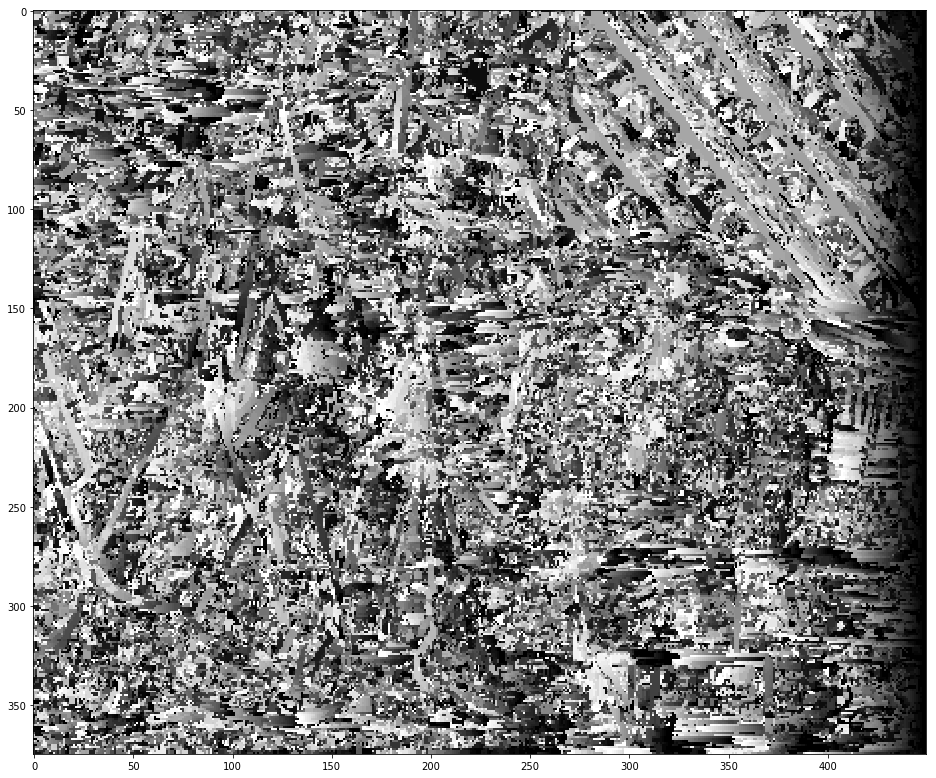

In [26]:
plt.figure(figsize=(16,16))
plt.imshow(dpm, cmap='gray')

In [9]:
list(image_sets)

['art', 'cones', 'dolls', 'reindeer', 'books', 'teddy']

In [10]:
img_set = list(image_sets)[3]

In [26]:
img_set

'reindeer'

In [40]:
img_left = cv2.imread(os.path.join(path_data, f'{img_set}_left.png'))
img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
img_right = cv2.imread(os.path.join(path_data, f'{img_set}_right.png'))
img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
img_disp = cv2.imread(os.path.join(path_data, f'{img_set}_disp.png'), cv2.IMREAD_GRAYSCALE)

img_left_gr = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
img_right_gr = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

In [66]:
dpm = calculate_disparity_map(
    img_left_gr,
    img_right_gr, 
    structural_similarity_index,
    11, 
    40
)

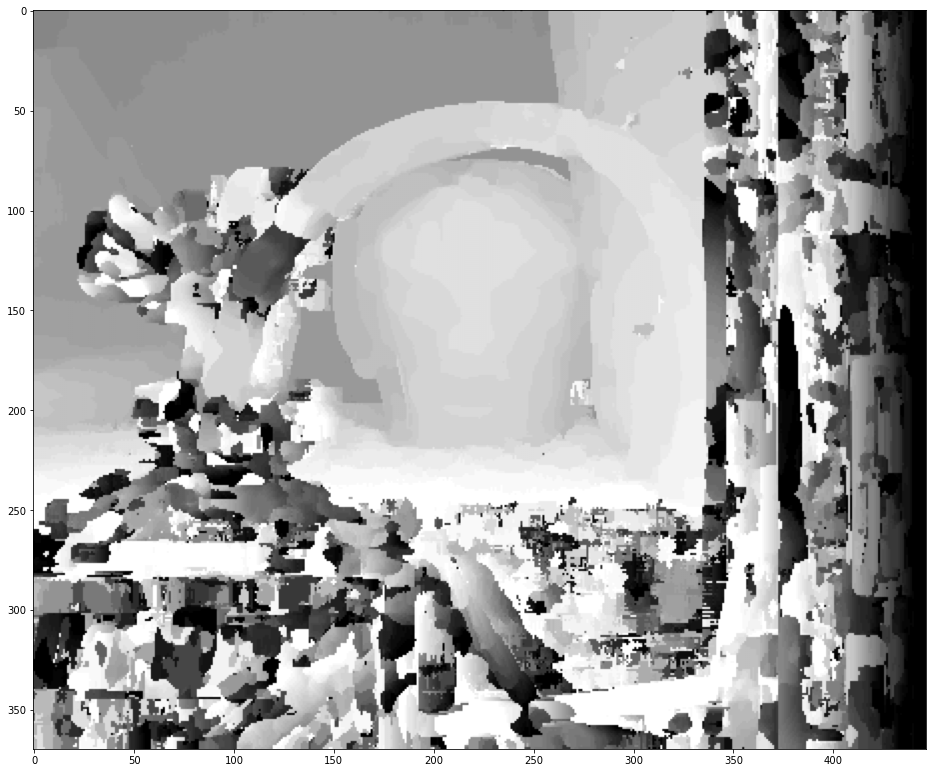

In [67]:
plt.figure(figsize=(16,16))
plt.imshow(dpm, cmap='gray')

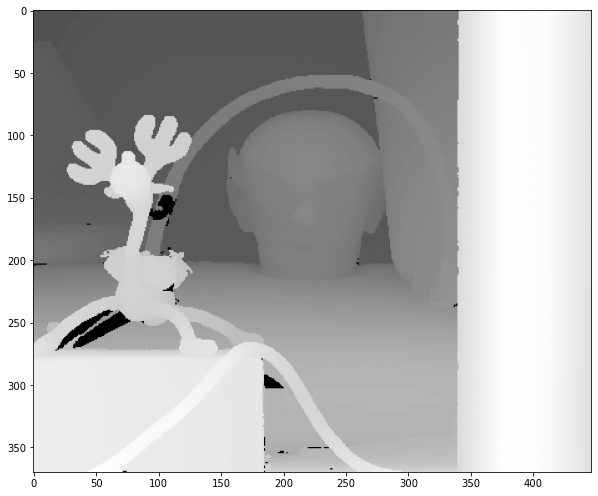

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(img_disp, cmap='gray')

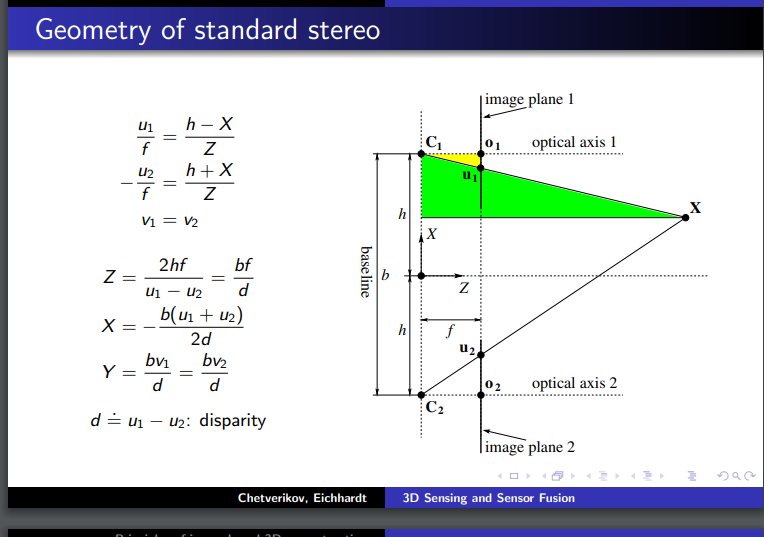

In [41]:
param_baseline = 160 # mm   ->     m ? 
param_focal_length = 3740 # pixels
dmin = 230

In [81]:
@njit
def reconstruct_3d_scene(
    left_image: np.ndarray, 
    right_image: np.ndarray, 
    disparity_image: np.ndarray,
    baseline: int,
    focal_length: int,
    dmin: int
) -> List[tuple]:
    '''
    '''
    rows, cols = left_image.shape[:2]
    points_3d_rgb = []
    
    for i in range(rows):
        for j in range(cols):
            
            disparity = disparity_image[i, j] + dmin
            
            if not disparity:
                continue
            # d = u1 - u2  ->  u2 = u1 - d
            # x = - b*(u1 + u2)/2d = - b*(2*u1-d)/2d
            
            x = round(-baseline * (2 * j - disparity)/(2*disparity), 4)
            y = -round(baseline * i / disparity, 4)
            z = round(baseline * focal_length / disparity, 4)
            rgb = left_image[i, j]
            
            #points_3d_rgb.append((x, y, z, *rgb))
            points_3d_rgb.append((x, y, z, rgb[0], rgb[1], rgb[2]))

    return points_3d_rgb

In [82]:
points = reconstruct_3d_scene(img_left, img_right, img_disp/3, param_baseline/1000, param_focal_length, dmin)
#points = reconstruct_3d_scene(img_left, img_right, dpm, param_baseline/1000, param_focal_length, dmin)

In [83]:
points

[(0.08, -0.0, 2.3841, 48, 19, 15),
 (0.0794, -0.0, 2.3841, 51, 19, 15),
 (0.0787, -0.0, 2.3841, 52, 18, 13),
 (0.0781, -0.0, 2.3841, 51, 16, 11),
 (0.0775, -0.0, 2.3841, 48, 14, 9),
 (0.0768, -0.0, 2.3841, 43, 12, 7),
 (0.0762, -0.0, 2.3841, 39, 13, 8),
 (0.0755, -0.0, 2.3809, 37, 13, 8),
 (0.0749, -0.0, 2.3809, 36, 12, 7),
 (0.0743, -0.0, 2.3809, 38, 12, 7),
 (0.0736, -0.0, 2.3809, 37, 13, 9),
 (0.073, -0.0, 2.3809, 41, 16, 11),
 (0.0724, -0.0, 2.3809, 44, 19, 14),
 (0.0717, -0.0, 2.3809, 48, 19, 16),
 (0.0711, -0.0, 2.3809, 51, 21, 17),
 (0.0705, -0.0, 2.3809, 48, 16, 12),
 (0.0698, -0.0, 2.3809, 45, 16, 10),
 (0.0692, -0.0, 2.3809, 44, 16, 9),
 (0.0685, -0.0, 2.3809, 43, 13, 8),
 (0.0679, -0.0, 2.3809, 40, 12, 8),
 (0.0673, -0.0, 2.3809, 39, 13, 7),
 (0.0666, -0.0, 2.3777, 39, 15, 7),
 (0.066, -0.0, 2.3777, 39, 13, 7),
 (0.0654, -0.0, 2.3777, 41, 13, 8),
 (0.0647, -0.0, 2.3777, 40, 14, 8),
 (0.0641, -0.0, 2.3777, 42, 15, 9),
 (0.0635, -0.0, 2.3777, 40, 13, 8),
 (0.0628, -0.0, 2.3777

In [63]:
with open('3d_scene.txt', 'w') as file:
    for point in points:
        file.write(' '.join(str(p) for p in point))
        file.write('\n')

In [ ]:
@njit
def calculate_disparity_map(
    left_image: np.ndarray,
    right_image: np.ndarray,
    metric: Callable,
    block_size: int,
    max_distance: int,
) -> np.ndarray:
    '''
    '''
    img_x, img_y = left_image.shape
    img_disp = np.zeros((img_x, img_y))

    for tcx in range(img_x):
        for tcy in range(img_y):

            cbs = int(np.ceil(block_size/2))
            template = left_image[max(0, tcx-cbs):min(tcx+cbs, img_x), max(0, tcy-cbs):min(tcy+cbs, img_y)]
            blocks = right_image[max(0, tcx-cbs):min(tcx+cbs, img_x), max(0, tcy-cbs):min(tcy+cbs+max_distance, img_y)]
            
            _, temp_y = template.shape
            _, bls_y = blocks.shape
            scores = []
            md = 0

            while md + temp_y <= bls_y:

                bl = blocks[:, md:md+temp_y]
                sc = metric(template, bl)
                scores.append(sc)
                md += 1

            img_disp[tcx, tcy] = np.argmin(np.array(scores))
        
    return img_disp

In [31]:
def calculate_disparities_for_row(
    row: int,
    left_image: np.ndarray,
    right_image: np.ndarray,
    metric: Callable,
    block_size: int,
    max_distance: int
) -> np.ndarray:
    '''
    '''
    img_x, img_y = left_image.shape
    row_disp = np.zeros(img_y)
    cbs = int(np.ceil(block_size/2))
    
    for tcy in range(img_y):

        template = left_image[max(0, row-cbs):min(row+cbs, img_x), max(0, tcy-cbs):min(tcy+cbs, img_y)]
        blocks = right_image[max(0, row-cbs):min(row+cbs, img_x), max(0, tcy-cbs):min(tcy+cbs+max_distance, img_y)]

        _, temp_y = template.shape
        _, bls_y = blocks.shape
        scores = []
        md = 0

        while md + temp_y <= bls_y:

            bl = blocks[:, md: md + temp_y]
            sc = metric(template, bl)
            scores.append(sc)
            md += 1

        row_disp[tcy] = np.argmin(np.array(scores))
        
    return (row, row_disp)

In [16]:
img_set = list(image_sets)[3]

img_left = cv2.imread(os.path.join(path_data, f'{img_set}_left.png'))
img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
img_right = cv2.imread(os.path.join(path_data, f'{img_set}_right.png'))
img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
img_disp = cv2.imread(os.path.join(path_data, f'{img_set}_disp.png'), cv2.IMREAD_GRAYSCALE)

img_left_gr = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
img_right_gr = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

In [56]:
rows = list(range(img_left.shape[0]))

row

369

In [68]:
func = functools.partial(
    calculate_disparities_for_row, 
    img_left_gr, 
    img_right_gr, 
    sum_of_squared_differences, 
    7, 
    55
)

res = process_map(
    func,
    rows,
    max_workers=2,
    chunksize=1
)

  0%|          | 0/370 [00:00<?, ?it/s]

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
func = functools.partial(
    calculate_disparities_for_row, 
    img_left_gr, 
    img_right_gr, 
    sum_of_squared_differences, 
    7, 
    55
)

with multiprocessing.Pool(processes=2) as pool:
    
    results = pool.map(func, rows)

In [66]:
res = []

for row in tqdm(rows):
    
    res.append(calculate_disparities_for_row(row, img_left_gr, img_right_gr, sum_of_squared_differences, 7, 55))

TypeError: 'module' object is not callable

In [52]:
res_sorted = sorted(res, key=lambda x: x[0])

In [53]:
img_disp = np.array([el[1] for el in res_sorted])

In [54]:
img_disp.shape

(370, 463)

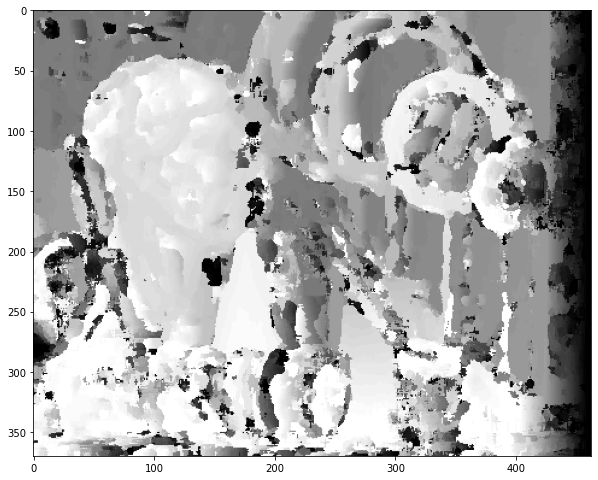

In [55]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(img_disp, cmap='gray')

In [49]:
dpm = calculate_disparity_map(
    img_left_gr,
    img_right_gr, 
    sum_of_squared_differences,
    7, 
    55
)

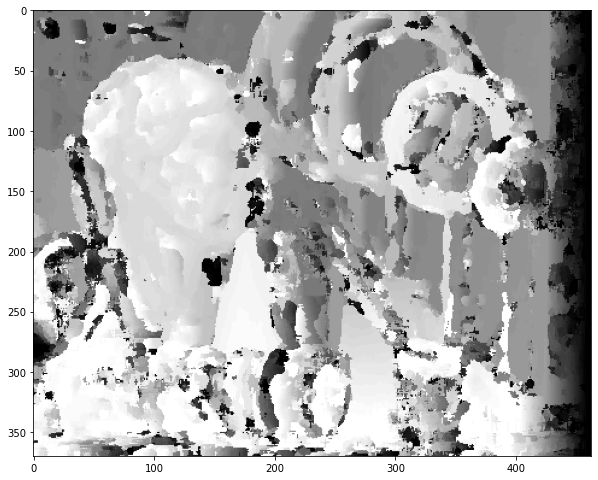

In [50]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(dpm, cmap='gray')